In [935]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
from edo_fdm_model import fdm
import matplotlib.pyplot as plt

In [936]:
k = 0.1
t_lower = 0.0
t_upper = 10
phi = 0.2
ksi = 0.0
cb = 0.15
C_nmax = 0.55
mi_n = 0.2
lambd_nb = 1.8
lambd_bn = 0.1
y_n = 0.1
initial = 0.5

size_t = int(((t_upper - t_lower) / (k)))

initial_var = 0.1

initial_list = np.linspace(
    initial * (1 - initial_var),
    initial * (1 + initial_var),
    num=size_t + 1,
    endpoint=True,
)

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t_np = np.linspace(t_lower, t_upper, num=size_t + 1, endpoint=True)

for i, initial in enumerate(initial_list):
    if i == 0:
        Cp_old, Cl_old = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lambd_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            initial,
            plot=False,
        )

    else:
        Cp_new, Cl_new = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lambd_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            initial,
            plot=False,
        )

        Cp_old = np.vstack((Cp_old.copy(), Cp_new))
        Cl_old = np.vstack((Cl_old.copy(), Cl_new))

Steps in time = 100



# Análise de nullclines

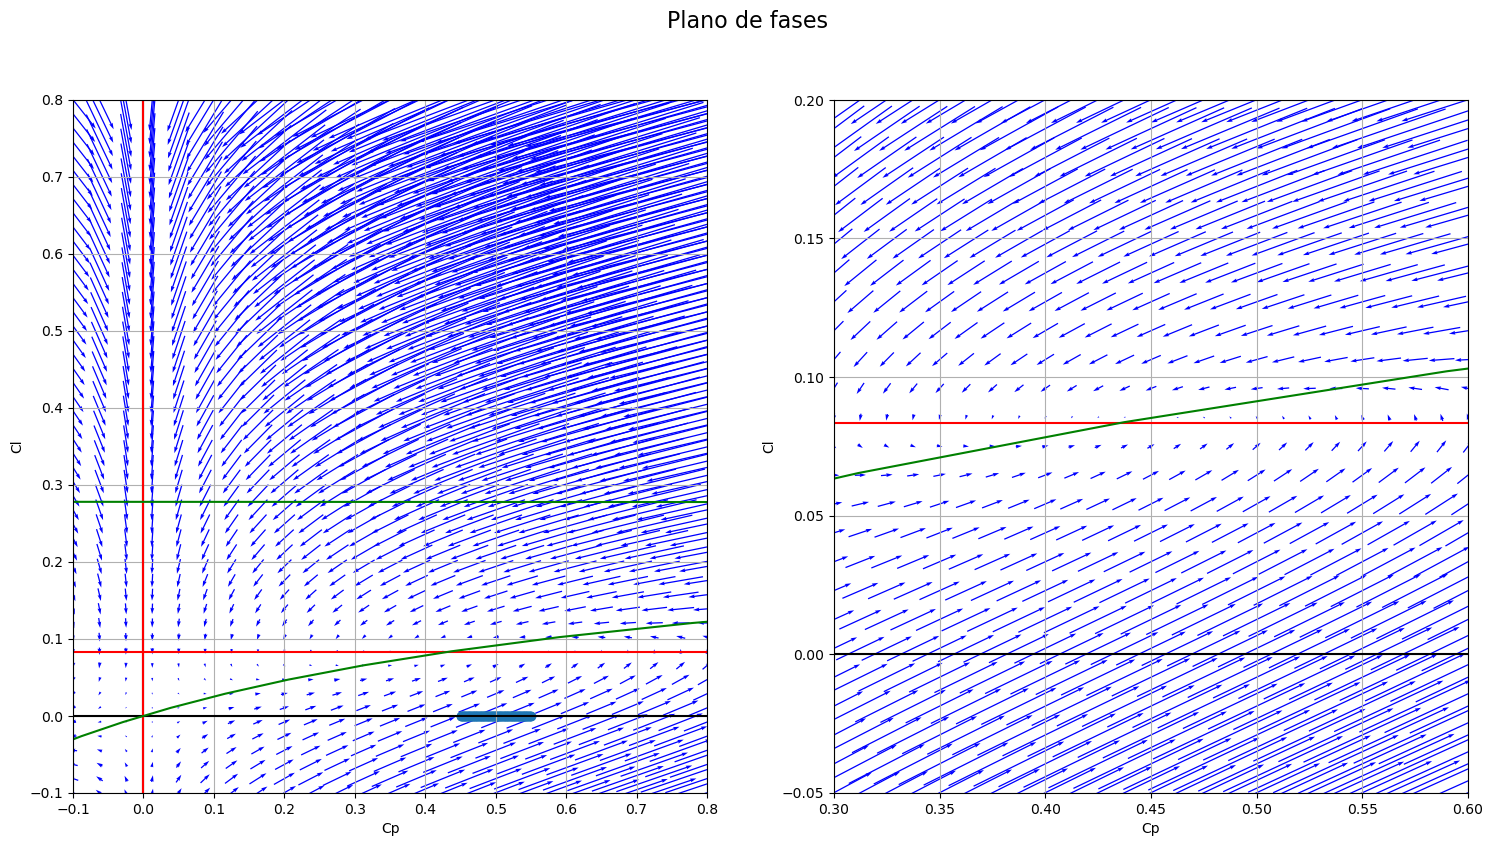

In [937]:
fig = plt.figure(figsize=[18, 9])

fig.suptitle("Plano de fases", fontsize=16)

  
# Plotango 3D
ax = fig.add_subplot(1, 2, 1)

x_lim = (-0.1,0.8)
y_lim = (-0.1,0.8)

const_cl = cb / lambd_nb

cp_eval = np.linspace(x_lim[0], x_lim[1], num=25, endpoint=True)
cl_eval = np.linspace(y_lim[0], y_lim[1], endpoint=True)

nulc_1 = [const_cl for i in range(len(cl_eval))]
nulc_2 = [0 for i in range(len(cl_eval))]

nulc_3 = mi_n*cl_eval/(y_n*(C_nmax-cl_eval)-lambd_bn*cl_eval)

# Meshgrid 
x, y = np.meshgrid(cp_eval,  
                   cl_eval) 
  
# Directional vectors 
u = (cb*x-lambd_nb*y*x)/phi
v = (y_n*x*(C_nmax-y)-lambd_bn*x*y-mi_n*y)/ phi

ax.set_xlabel("Cp")
ax.set_ylabel("Cl")

ax.hlines(0, x_lim[0], x_lim[1], "k")
ax.vlines(0, y_lim[0], y_lim[1], "k")

ax.plot(
    cl_eval,
    nulc_1,
    "r"
)

ax.plot(
    nulc_2,
    cl_eval,
    "r"
)

ax.plot(
    nulc_3,
    cl_eval,
    "g"
)

# Plotting Vector Field with QUIVER 
ax.quiver(x, y, u, v, color='b',width=0.002,angles='xy', scale_units='xy', scale=10, pivot="mid") 

# Plotando valores de condições iniciais estudados
ax.scatter(initial_list,[0 for i in range(len(initial_list))]) 

ax.grid()
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])

# Plotango 3D
ax = fig.add_subplot(1, 2, 2)

x_lim = (0.3,0.6)
y_lim = (-0.05,0.2)

const_cl = cb / lambd_nb

cp_eval_2 = np.linspace(x_lim[0], x_lim[1], num=25, endpoint=True)
cl_eval_2 = np.linspace(y_lim[0], y_lim[1], num=25, endpoint=True)

# Meshgrid 
x, y = np.meshgrid(cp_eval_2,  
                   cl_eval_2) 
  
# Directional vectors 
u = (cb*x-lambd_nb*y*x)/phi
v = (y_n*x*(C_nmax-y)-lambd_bn*x*y-mi_n*y)/ phi

ax.set_xlabel("Cp")
ax.set_ylabel("Cl")

ax.hlines(0, x_lim[0], x_lim[1], "k")
ax.vlines(0, y_lim[0], y_lim[1], "k")

ax.plot(
    cl_eval,
    nulc_1,
    "r"
)

ax.plot(
    nulc_2,
    cl_eval,
    "r"
)

ax.plot(
    nulc_3,
    cl_eval,
    "g"
)

# Plotting Vector Field with QUIVER 
ax.quiver(x, y, u, v, color='b',width=0.002,angles='xy', scale_units='xy', scale=10, pivot="mid") 

ax.grid()
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])

plt.show()

# PINN

In [938]:
tt, ii = np.meshgrid(t_np, initial_list)

data_input_np = np.array([Cl_old.flatten(), Cp_old.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    initial = (
        torch.tensor(ii, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    initial = torch.tensor(ii, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

cuda


In [939]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [940]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [941]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](2, int(out_neurons)))

                else:
                    modules.append(nn.Linear(2, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [942]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [943]:
def normalize_torch(dataset):
    with torch.no_grad():
        dt_min = torch.min(dataset,0).values
        dt_max = torch.max(dataset,0).values
        normalized = (dataset- dt_min)/(dt_max-dt_min)
    
    return normalized.requires_grad_(True), dt_min, dt_max


In [944]:
def normalize_data_input(data_input,steps):
    with torch.no_grad():
        dataset = data_input.reshape(steps,steps,2)
        normalized = torch.zeros_like(dataset)
        for i in range(len(dataset)):
            dt_min = torch.min(dataset[i],0).values
            dt_max = torch.max(dataset[i],0).values
            normalized[i] = (dataset[i]- dt_min)/(dt_max-dt_min)
    
    return normalized.reshape((steps)*(steps),2)

In [945]:
def rescale(dataset,dt_min,dt_max):
    return (dt_max-dt_min)*dataset + dt_min

In [946]:
def initial_condition(initial):
    Cl = torch.zeros_like(initial)
    return torch.cat([Cl, initial], dim=1)

In [947]:
def pde(t, initial,model):
    mesh = torch.cat([t, initial], dim=1)

    Cl, Cp = model(mesh).split(1, dim=1)

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Calculando Cp
    
    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]


    return torch.cat([dCl_dt, dCp_dt], dim=1)

In [948]:
def train(
    n_epochs,
    batch_size,
    decay_rate,
    model,
    initial,
    device,
    data_input,
    t,
    norm_weights=None,
):

    dt_min, dt_max = norm_weights if norm_weights else (0, 1)

    print(dt_min, dt_max)

    loss_fn = nn.MSELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )
    decay_rate = 0.999

    C_pde_loss_it = torch.zeros(n_epochs).to(device)
    C_data_loss_it = torch.zeros(n_epochs).to(device)
    C_initial_loss_it = torch.zeros(n_epochs).to(device)
    C_initial = initial_condition(initial).to(device)

    for epoch in range(n_epochs):
        for i in range(0, len(t), batch_size):
            t_initial = torch.zeros_like(t[i : i + batch_size])

            mesh_ini = torch.cat([t_initial, initial[i : i + batch_size]], dim=1)
            C_initial_pred = model(mesh_ini)

            loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

            mesh = torch.cat(
                [t[i : i + batch_size], initial[i : i + batch_size]], dim=1
            )

            Cl, Cp = model(mesh).split(1, dim=1)

            Cl_eq = (y_n * Cp * (C_nmax - Cl) - lambd_bn * Cp * Cl - mi_n * Cl) / (
                phi * (dt_max - dt_min)
            )
            Cp_eq = (cb * Cp - lambd_nb * Cl * Cp) / (phi * (dt_max - dt_min))

            loss_pde = loss_fn(
                pde(
                    t[i : i + batch_size],
                    initial[i : i + batch_size],
                    model,
                ),
                torch.cat([Cl_eq, Cp_eq], dim=1),
            )

            loss_data = loss_fn(
                torch.cat([Cl, Cp], dim=1), data_input[i : i + batch_size]
            )

            loss = 80 * loss_initial + loss_pde + 10 * loss_data

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            # print("initial",initial)
            # print("C_initial",C_initial)
            # print("mesh_ini",mesh_ini)
            # print("C_initial_pred",C_initial_pred)
            # print("C_initial[i : i + batch_size]",C_initial[i : i + batch_size])
            # print("*"*30)

        C_pde_loss_it[epoch] = loss_pde.item()
        C_initial_loss_it[epoch] = loss_initial.item()
        C_data_loss_it[epoch] = loss_data.item()

        if (epoch % 100) == 0:
            print(f"Finished epoch {epoch+1}, latest loss {loss}")
            
    return model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it

In [949]:

decay_rate = 0.999
n_epochs = 500
batch_size = 1000

norm_initial, initial_min, initial_max = normalize_torch(initial)
norm_t, t_min, t_max = normalize_torch(t)
norm_data_input = normalize_data_input(data_input,size_t+1)

In [950]:
model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial=initial,
    device=device,
    data_input=data_input,
    t=t,
)

0 1


Finished epoch 1, latest loss 13.6940336227417
Finished epoch 101, latest loss 0.02905214950442314
Finished epoch 201, latest loss 0.0033403239212930202
Finished epoch 301, latest loss 0.0009572370909154415
Finished epoch 401, latest loss 0.0006362800486385822


In [951]:
# model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it = train(
#     n_epochs=n_epochs,
#     batch_size=batch_size,
#     decay_rate=decay_rate,
#     model=model,
#     initial=norm_initial,
#     device=device,
#     data_input=norm_data_input,
#     t=norm_t,
#     norm_weights=(initial_min, initial_max)
# )

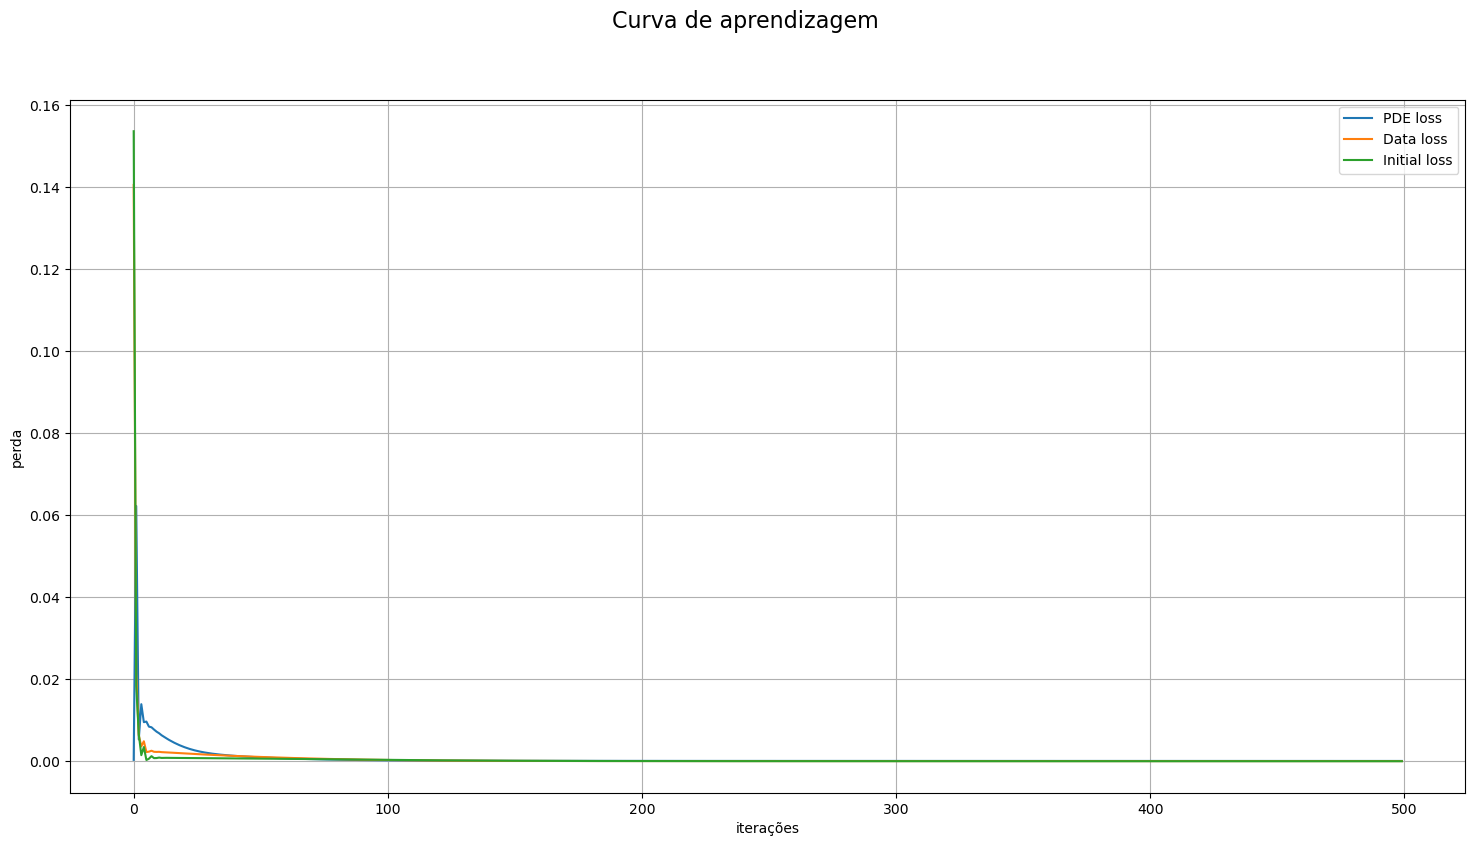

In [952]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [953]:
model_cpu = model.to("cpu")

speed_up = []

mesh = torch.cat([t, initial], dim=1).to("cpu")

for i in range(10):
    fdm_start = time.time()

    for ini in initial_list:

        _, _ = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lambd_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            ini,
        )

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(mesh).split(1, dim=1)

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [954]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

In [955]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [956]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.003982591
Erro absoluto máximo 0.022186935
Speed Up: 2.332291710989176 +/-1.5831571167016707


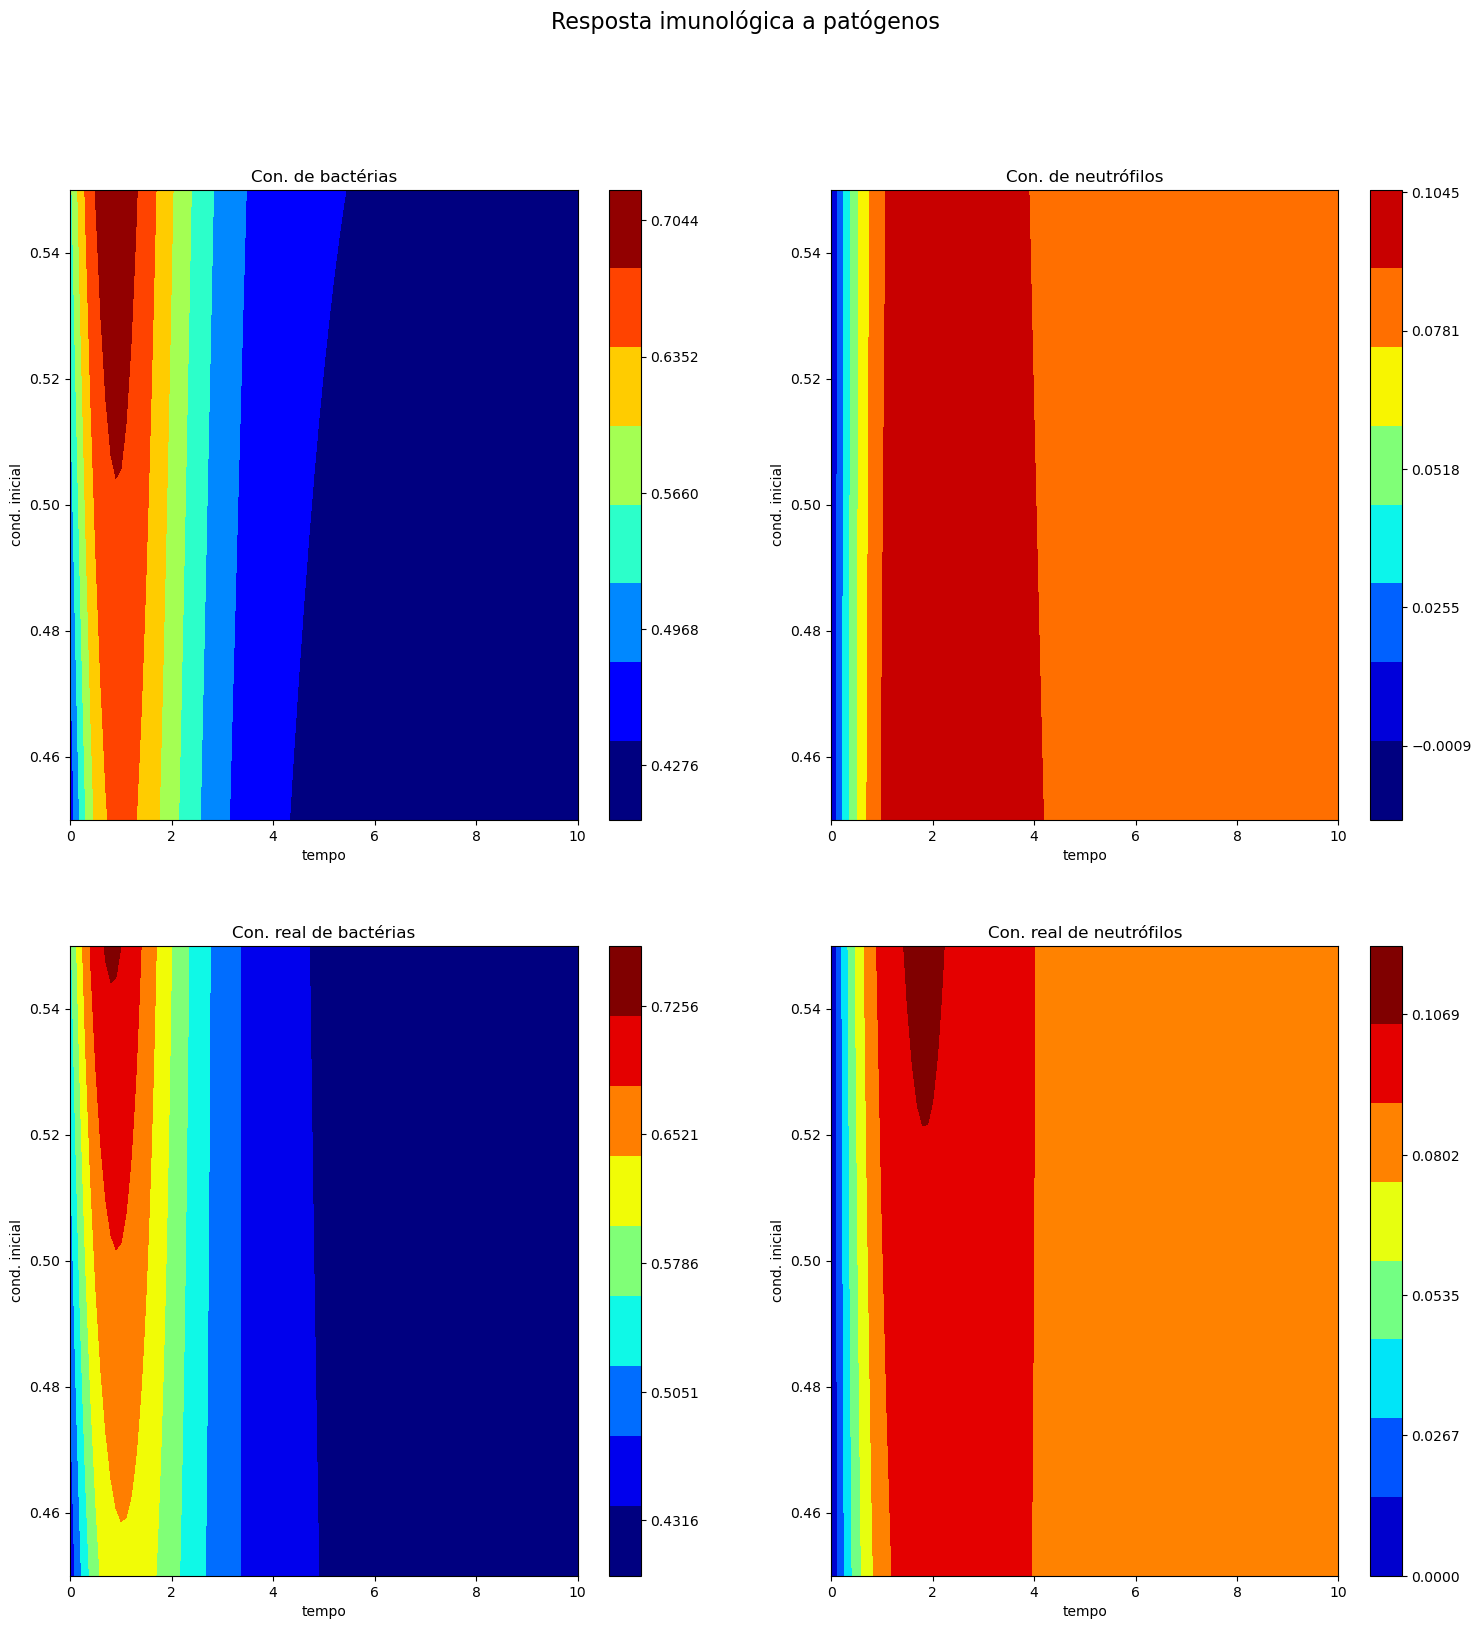

In [957]:
Cl_pinn_np = Cl_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)
Cp_pinn_np = Cp_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)

fig = plt.figure(figsize=[18, 18])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)


# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

vmin = np.min(Cp_pinn_np)
vmax = np.max(Cp_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

vmin = np.min(Cl_pinn_np)
vmax = np.max(Cl_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

vmin = np.min(Cp_old)
vmax = np.max(Cp_old)

contour = ax.contourf(
    tt,
    ii,
    Cp_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

vmin = np.min(Cl_old)
vmax = np.max(Cl_old)

contour = ax.contourf(
    tt,
    ii,
    Cl_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("cond. inicial")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

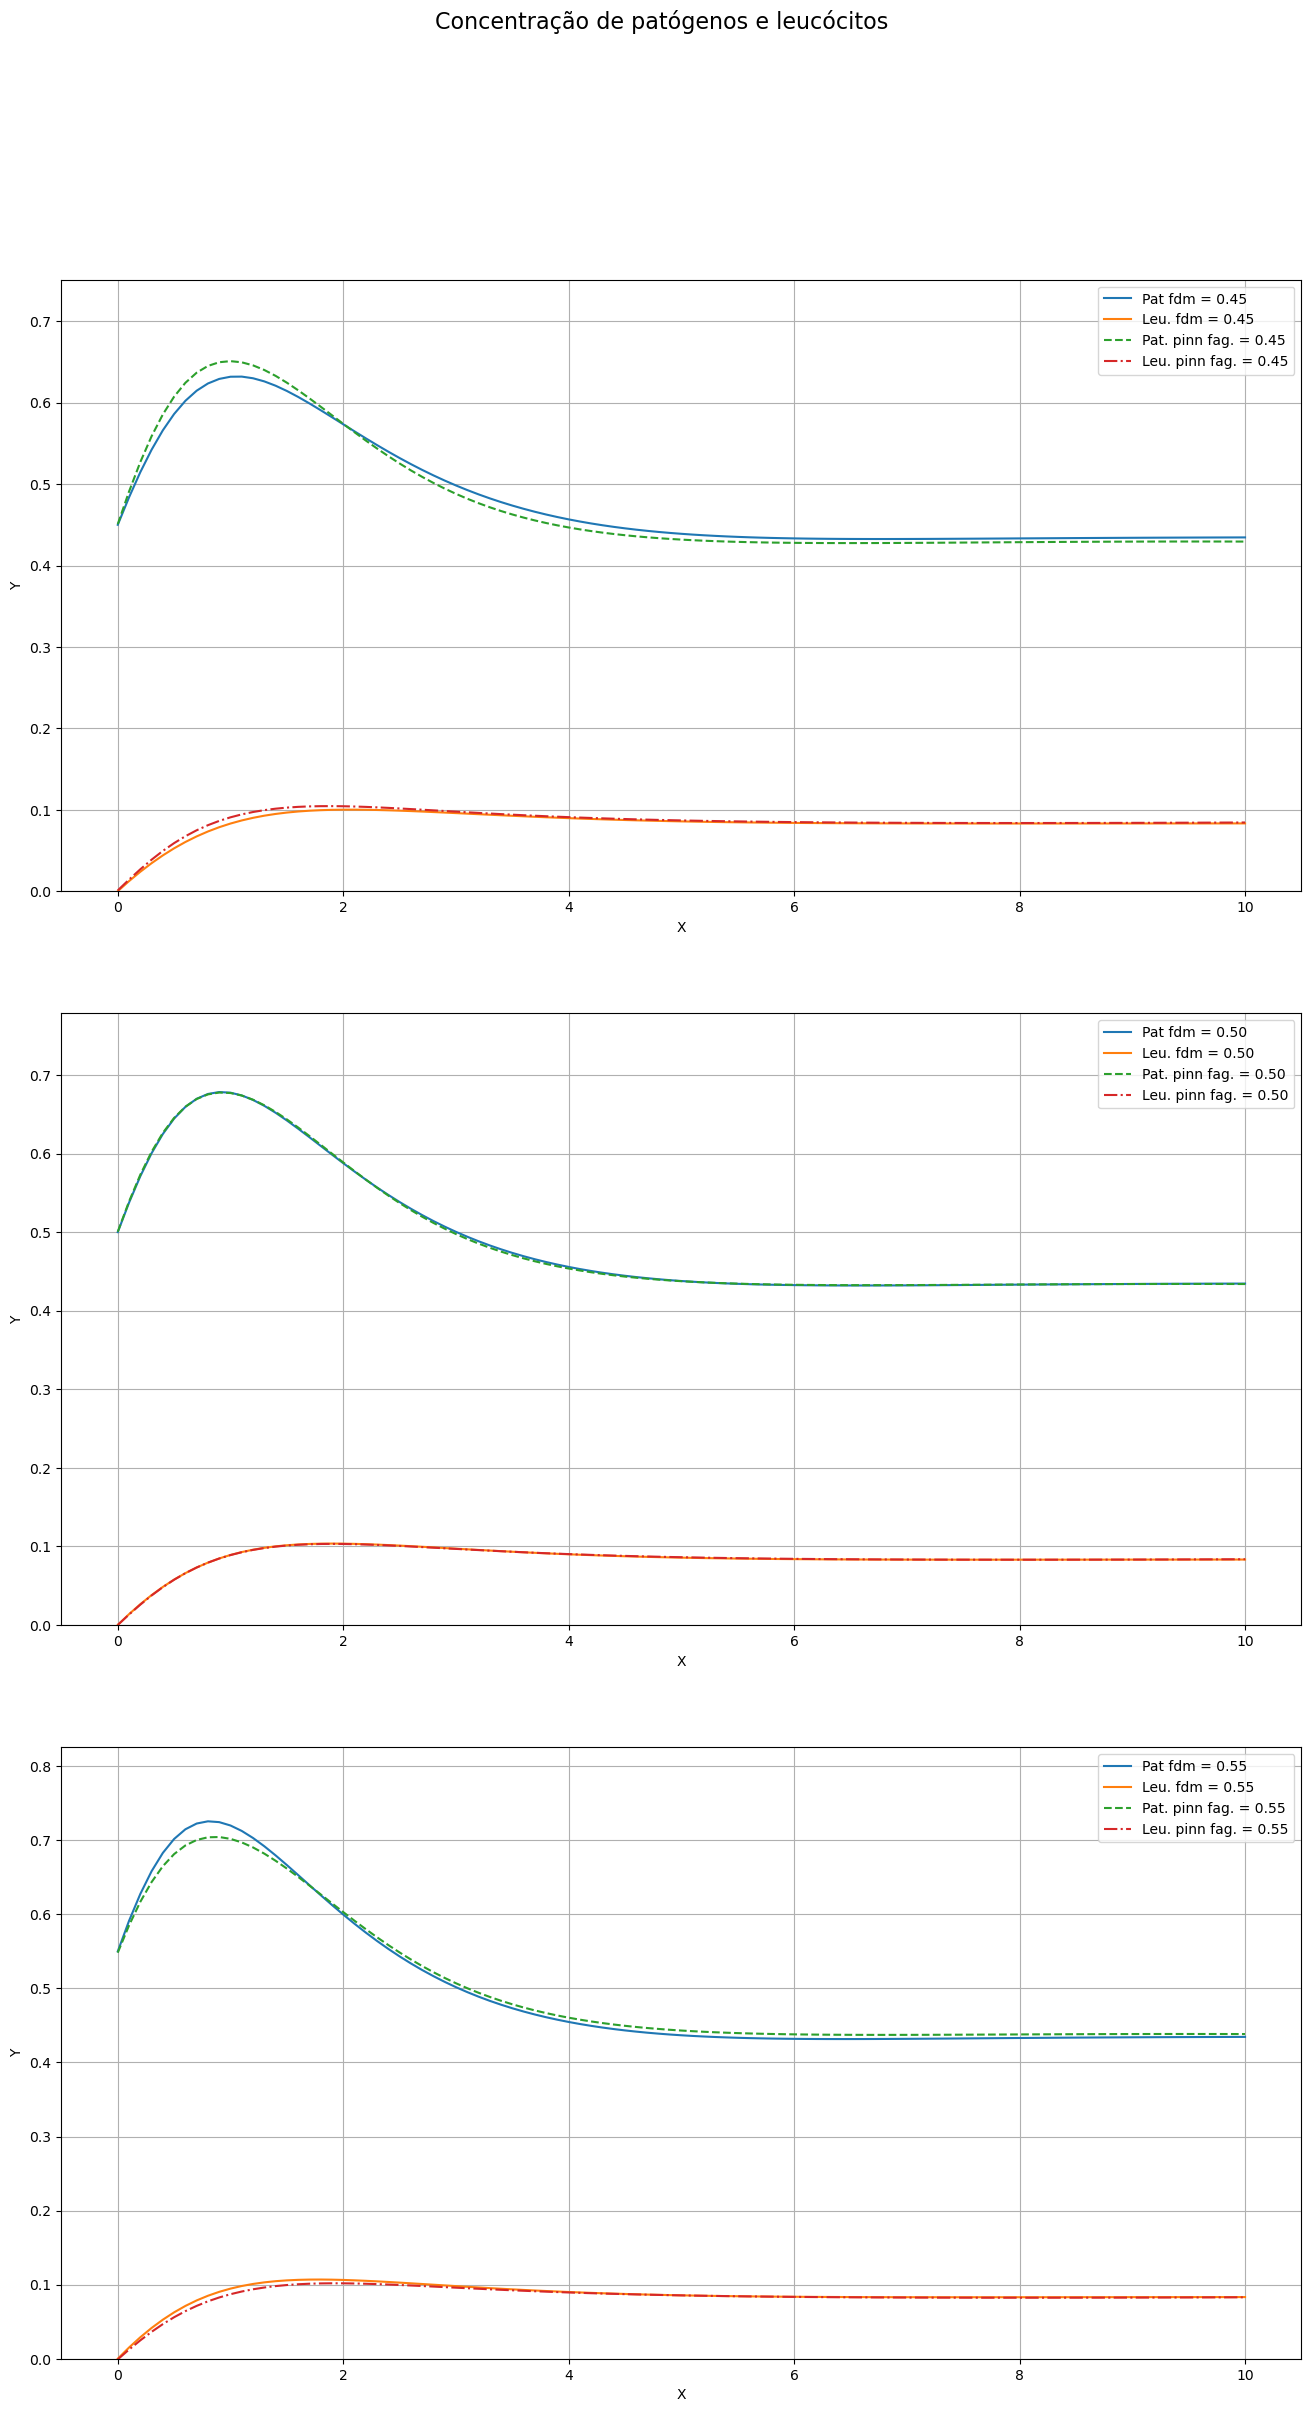

In [958]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp_old[0, :]
cl_real_1 = Cl_old[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
ini_1 = initial[0 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_2 = Cp_old[50, :]
cl_real_2 = Cl_old[50, :]
cp_pinn_2 = Cp_pinn_np[50, :]
cl_pinn_2 = Cl_pinn_np[50, :]
ini_2 = initial[50 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_3 = Cp_old[100, :]
cl_real_3 = Cl_old[100, :]
cp_pinn_3 = Cp_pinn_np[100, :]
cl_pinn_3 = Cl_pinn_np[100, :]
ini_3 = initial[100 * (size_t + 1)].cpu().detach().numpy()[0]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(ini_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(ini_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(ini_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(ini_2))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(ini_2))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(ini_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(ini_3))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(ini_3))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(ini_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(ini_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()